C:\Users\HOME\AppData\Local\Temp\ipykernel_5620\2258441063.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M').sum(
C:\Users\HOME\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training SimpleRNN model...
SimpleRNN Model - Final Loss: 0.0226, Final Accuracy: 1.0000
Training LSTM model...
LSTM Model - Final Loss: 0.0137, Final Accuracy: 1.0000
Training GRU model...
GRU Model - Final Loss: 0.0570, Final Accuracy: 1.0000


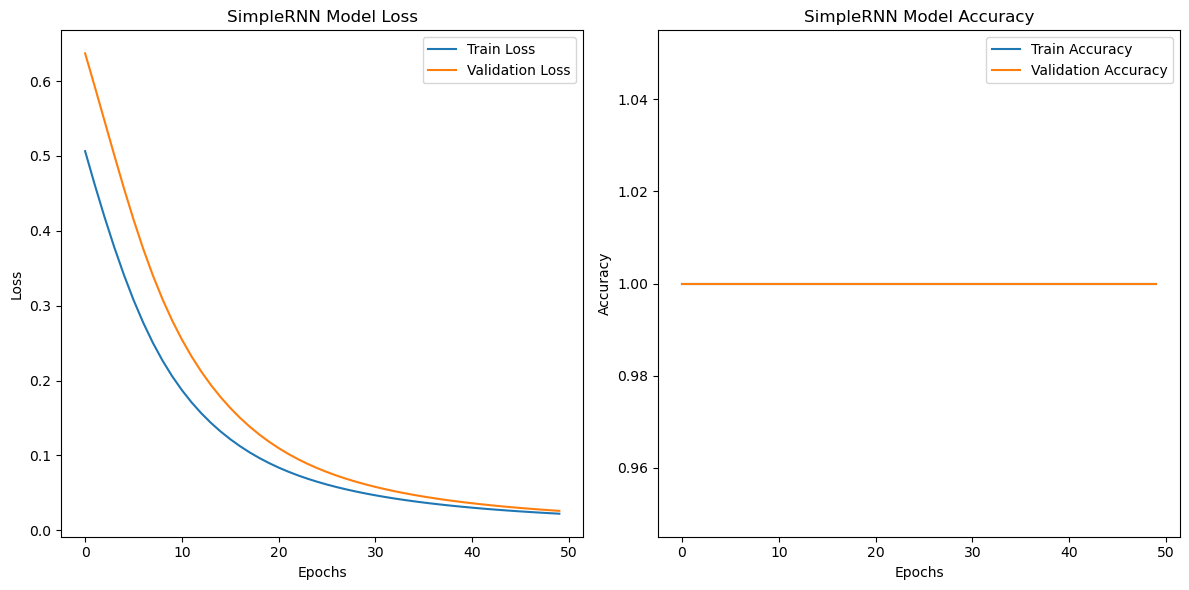

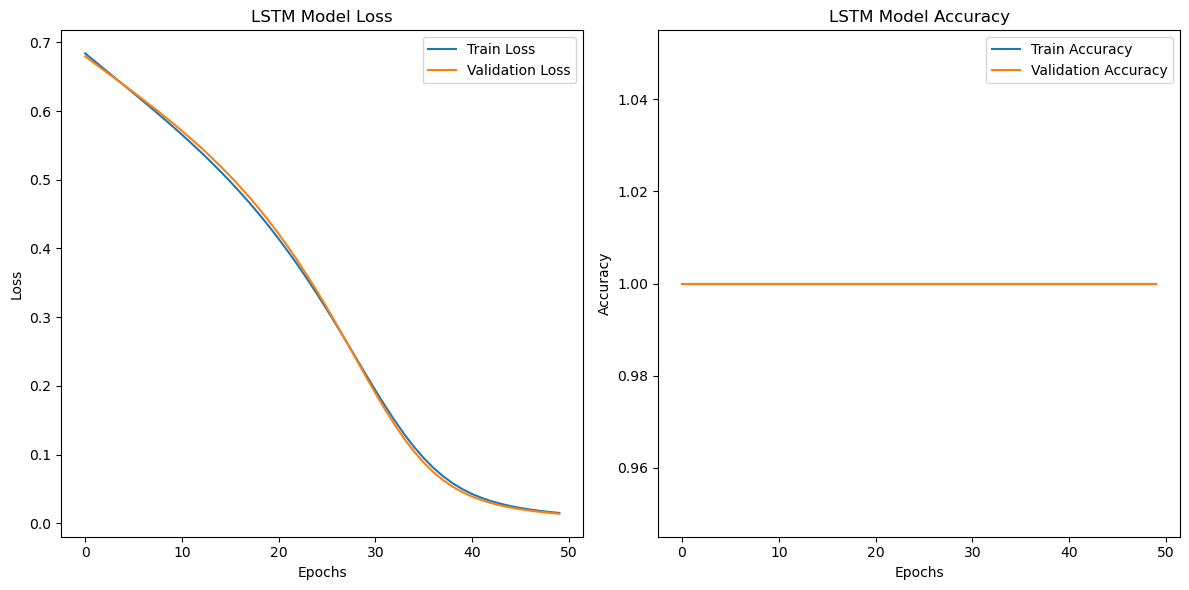

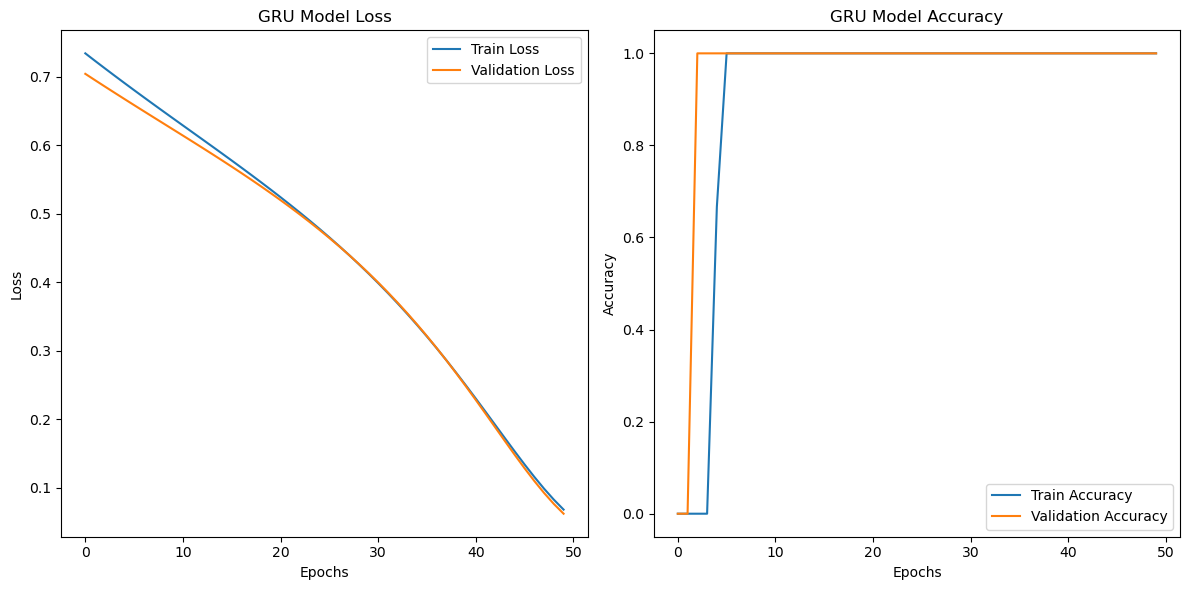


Final Results:
SimpleRNN Model - Loss: 0.0226, Accuracy: 1.0000
LSTM Model - Loss: 0.0137, Accuracy: 1.0000
GRU Model - Loss: 0.0570, Accuracy: 1.0000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam

# Load dataset
data = pd.read_csv('Penjualan.csv')  # Ganti dengan nama file dataset Anda
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)

# Aggregate monthly sales
monthly_sales = data.resample('M').sum(
)['nominal']  # Agregat penjualan bulanan
monthly_sales = monthly_sales.values.reshape(-1, 1)

# Binarize target (untuk klasifikasi)
# Menggunakan persentil 75 sebagai threshold
threshold = np.percentile(monthly_sales, 75)
binary_target = (monthly_sales > threshold).astype(int)

# Normalize data
scaler = MinMaxScaler()
monthly_sales_scaled = scaler.fit_transform(monthly_sales)

# Prepare data for time-series forecasting


def create_dataset(data, target, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(target[i + time_steps, 0])
    return np.array(X), np.array(y)


time_steps = 12  # Menggunakan 12 bulan sebelumnya untuk memprediksi bulan berikutnya
X, y = create_dataset(monthly_sales_scaled, binary_target, time_steps)

# Reshape X for RNN input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Function to build and train a model


def build_and_train_model(model_type):
    model = Sequential()

    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(64, input_shape=(
            X.shape[1], 1), return_sequences=True))
        model.add(Dropout(0.2))  # Regularisasi dengan Dropout
        model.add(SimpleRNN(32))
    elif model_type == 'LSTM':
        model.add(LSTM(64, input_shape=(X.shape[1], 1), return_sequences=True))
        model.add(Dropout(0.2))  # Regularisasi dengan Dropout
        model.add(LSTM(32))
    elif model_type == 'GRU':
        model.add(GRU(64, input_shape=(X.shape[1], 1), return_sequences=True))
        model.add(Dropout(0.2))  # Regularisasi dengan Dropout
        model.add(GRU(32))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X, y, epochs=100, batch_size=32,
                        validation_split=0.2, verbose=0)

    # Evaluate the model on training data
    final_loss, final_accuracy = model.evaluate(X, y, verbose=0)
    return model, history, final_loss, final_accuracy


# Train and evaluate models
models = {}
histories = {}
results = {}

for model_type in ['SimpleRNN', 'LSTM', 'GRU']:
    print(f"Training {model_type} model...")
    model, history, final_loss, final_accuracy = build_and_train_model(
        model_type)
    models[model_type] = model
    histories[model_type] = history
    results[model_type] = {'loss': final_loss, 'accuracy': final_accuracy}
    print(f"{model_type} Model - Final Loss: {final_loss:.4f}, Final Accuracy: {final_accuracy:.4f}")

# Plot accuracy and loss for each model
for model_type, history in histories.items():
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type} Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Display final loss and accuracy for each model
print("\nFinal Results:")
for model_type, result in results.items():
    print(
        f"{model_type} Model - Loss: {result['loss']:.4f}, Accuracy: {result['accuracy']:.4f}")